In [27]:
import numpy as np
from itertools import combinations
from scipy.stats import binom
import scipy.special
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
from decimal import *

In [9]:
def get_index_lists_I_and_J(E,n,N,d):
    I_n = list(range(d))
    J_n = list(range(d))
    n_ = n+1
    for m in reversed(range(d)):
        if E[m,n_-1] in E[J_n,n_]:
            del I_n[m]
            t_J_n = [i for i in J_n if E[i,n_] == E[m,n_-1] ]
            m_max = max(t_J_n)
            del J_n[m_max]
    return I_n,J_n

In [10]:
def diff_of_lists(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [11]:
def get_permutation_I(I_n,d):
    permutation = [0]*d
    r_n = np.shape(I_n)[0]
    complementary_I_n = diff_of_lists(list(range(d)),I_n)
    c_r_n = d-r_n
    for i in range(r_n):
        permutation[I_n[i]] = i
    for i in range(c_r_n):
        permutation[complementary_I_n[i]] = i + r_n
    return permutation

In [12]:
def get_v_n_w_n(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n = np.zeros((r_n))
    w_n = np.zeros((r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        v_n_index = permutation_I_n[m]
        nom_v_n = E[m,n]*np.ones((r_n,1)) - E[list(J_n),n+1]
        I_n_without_m = diff_of_lists(I_n,[m])
        cardinal_I_n_without_m = np.shape(I_n_without_m)[0]
        denom_v_n = E[m,n]*np.ones((cardinal_I_n_without_m,1)) - E[list(I_n_without_m),n]
        v_n[v_n_index] = np.sqrt(-np.prod(nom_v_n)/np.prod(denom_v_n))
    for m in J_n:
        w_n_index = permutation_J_n[m]
        nom_w_n = E[m,n+1]*np.ones((r_n,1)) - E[list(I_n),n]
        J_n_without_m = diff_of_lists(J_n,[m])
        cardinal_J_n_without_m = np.shape(J_n_without_m)[0]
        denom_w_n = E[m,n+1]*np.ones((cardinal_J_n_without_m,1)) - E[list(J_n_without_m),n+1]
        w_n[w_n_index] = np.sqrt(np.prod(nom_w_n)/np.prod(denom_w_n))
        
    return v_n,w_n

In [13]:
def get_permutation_matrix(permutation,d):
    permutation_matrix = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            if i == permutation[j]:
                permutation_matrix[i,j] = 1
    return permutation_matrix

In [14]:
def get_W_n_matrix(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n)
    W_n_matrix = np.zeros((r_n,r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        for m_ in J_n:
            v_n_index = permutation_I_n[m]
            w_n_index = permutation_J_n[m_]
            W_n_matrix[v_n_index,w_n_index] = 1/(E[m_,n+1]-E[m,n])*v_n[v_n_index]*w_n[w_n_index]
    return W_n_matrix

In [15]:
def get_padded_vector(v,d):
    r_n = np.shape(v)[0]
    v_padded = np.zeros((d,))
    v_padded[0:r_n] = v
    return v_padded

In [16]:
def get_extended_matrix_W(W_n_matrix,d):
    r_n = np.shape(W_n_matrix)[0]
    W_extended = np.eye(d)
    W_extended[0:r_n,0:r_n] = W_n_matrix
    return W_extended

In [17]:
def get_F(d,N,E,mu_vector):
    F_test = np.zeros((d,N))
    U_n_1 = np.eye(d)
    for n in range(N):
        #print(n)
        if n ==0:
            M = np.eye(d)
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,M)
        else:
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,U_n_1)
    return F_test

In [18]:
def generate_random_diagonal_unimodular_matrix(d):
    vector = np.ones((1,d)) - 2*np.random.binomial(1, 0.5, d)
    return np.diag(vector[0])
    #return np.eye(d)

In [19]:
def get_F_n_U_n(n,d,N,E,mu_vector,U_n_1):
    #print(n)
    if n==1:
        M = np.eye(d)
        v = np.sqrt(mu_vector[0])*M[:,0]
        return v,np.eye(d)
    I_n,J_n = get_index_lists_I_and_J(E,n-1,N,d)
    r_n = np.shape(I_n)[0]
    permutation_matrix_I_n = get_permutation_matrix(get_permutation_I(I_n,d),d)
    permutation_matrix_J_n = get_permutation_matrix(get_permutation_I(J_n,d),d)
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n-1)
    W_extended = get_extended_matrix_W(get_W_n_matrix(E,I_n,J_n,d,n-1),d)
    v_padded = get_padded_vector(v_n,d)
    V_n = generate_random_diagonal_unimodular_matrix(d)
    U_n = np.dot(np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),W_extended),permutation_matrix_J_n)
    f_n = np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),v_padded)
    return f_n,U_n

## Create an eigensteps

In [118]:
list(range(17, -1, -1))

[17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [513]:
def generate_leverage_scores_vector_with_dirichlet(d,k,nn_cardinal):
    getcontext().prec = 3
    mu_vector = np.float16(np.zeros((d,)))
    mu_vector_2 = np.float16(np.zeros((d,)))
    not_bounded = 1
    while(not_bounded == 1):
        mu_vector[0:nn_cardinal] = (k*np.random.dirichlet([1]*nn_cardinal, 1))[0]
        mu_vector = np.flip(np.sort(mu_vector),axis = 0)
        if max(mu_vector)<=1:
            not_bounded = 0
    for i in range(nn_cardinal):
        mu_vector_2[i] = round(mu_vector[i],3)
    numbers = [ int(1000*x) for x in mu_vector_2 ] 
    print(numbers)
    print(np.sum(numbers))
    numbers[nn_cardinal-1] = 1000*k-np.sum(numbers[0:nn_cardinal-1])
    numbers_to_float = 1/1000*np.asarray([float(x) for x in numbers])
    print(np.sum(numbers_to_float))
    mu_vector_2 = k*numbers_to_float/np.sum(numbers_to_float)
    return list(mu_vector_2)

In [538]:
lv_vector = generate_leverage_scores_vector_with_dirichlet(20,4,15)

[898, 659, 591, 458, 333, 234, 161, 157, 114, 109, 101, 86, 35, 29, 27, 0, 0, 0, 0, 0]
3992
4.0


In [515]:
lv_vector

[0.82600000000000007,
 0.63200000000000001,
 0.41600000000000009,
 0.31,
 0.29099999999999998,
 0.28999999999999998,
 0.11900000000000001,
 0.094000000000000014,
 0.012000000000000002,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [22]:
def get_eigensteps_mean(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        #print(n)
        for k in range(n, -1, -1):
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n,n])
            B_n_1_k = min(E[k,n+1],min(B_array))
            u = np.random.uniform(0,1)
            E[k,n] = A_n_1_k
    return E

In [91]:
list(range(18, -1, -1))

[18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

In [486]:
np.random.choice(5, 3,replace=False)

array([4, 1, 2])

In [ ]:
def generate_decimal_leverage_scores_vector(d,k):
    pre_list = np.random.choice(d-1, 3,replace=False)

In [98]:
np.shape(np.zeros(19))

(19,)

In [99]:
list(range(3+1))

[0, 1, 2, 3]

In [78]:
N= 50
d = 20
E = np.zeros((N,N)) #(d,N)
mu_vector = d/N*np.ones((N,1))
lambda_vector = np.zeros((N))
lambda_vector[0:d] = np.ones((d))
N = None
d = None
E = None
mu_vector = None

In [386]:
def generate_orthonormal_matrix_with_leverage_scores_ES(N,d,lv_scores_vector,versions_number,nn_cardinal_list):

    lambda_vector = np.zeros((N))
    lambda_vector[0:d] = np.ones((d))

    #mu_vector = np.linspace(1, 0.1, num=N)
    #sum_mu_vector = np.sum(mu_vector)
    #mu_vector = d/sum_mu_vector*mu_vector
    Q = np.zeros((N,d))
    previous_Q = np.zeros((versions_number,N,d))
    #mu_vector = d/N*np.ones((N,1))
    E = np.zeros((N,N)) #(d,N)
    counter = 0
    for j in nn_cardinal_list:
        print(j)
        #print("counter")
        #print(counter)
        mu_vector = generate_leverage_scores_vector_with_dirichlet(N,d,j)
        #print(mu_vector)
        #print(np.sum(mu_vector))
        print(mu_vector)
        E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
        print(E_test)
        E_ = np.zeros((d,N+1))
        for i in range(d):
            E_[i,1:N+1] = E_test[i,:] 
        F_test = get_F(d,N,np.asmatrix(E_),mu_vector)
        previous_Q[counter,:,:] = np.transpose(F_test)
        Q = np.transpose(F_test)
        counter = counter +1
    return Q,previous_Q

In [36]:
static_list = list(range(11,21))

In [516]:
def get_eigensteps_random(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    #mu_vector = [0.89209, 0.83838, 0.55615, 0.36011, 0.35229]
    #mu_vector = [0.8923, 0.8382, 0.5563, 0.3610, 0.3522]
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        print("n")
        print(n)
        for k in range(n, -1, -1):
            print("k")
            print(k)
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n+1,n])
            #if k >0:
            B_n_1_k = min(E[k,n+1],min(B_array))
            #else:
            #    B_n_1_k = min(E[k,n+1],np.sum(mu_vector[k:n+1])-np.sum(E[k+1:n+1,n]))
            if B_n_1_k<A_n_1_k:
                E[k,n] = B_n_1_k
                print("error")
                print(1)   
            else:
                u = np.random.uniform(0,1)
                delta_n_1_k = B_n_1_k - A_n_1_k
                E[k,n] = A_n_1_k + u*delta_n_1_k
            print("A_n_1_k")
            print(Decimal(A_n_1_k))
            print("B_n_1_k")
            print(Decimal(B_n_1_k))
            #u = np.random.uniform(0,1)
            #delta_n_1_k = B_n_1_k - A_n_1_k
            #E[k,n] = A_n_1_k + u*delta_n_1_k
    return E

In [471]:
list(range(1, 19))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [490]:
list_1 = [0.99414, 0.76221, 0.63379, 0.56299, 0.04599]

In [491]:
numbers = [ int(100*x) for x in list_1 ] 

In [492]:
numbers

[99, 76, 63, 56, 4]

In [472]:
np.sum([0.89209, 0.83838, 0.55615, 0.36011, 0.35229])

2.9990200000000002

In [473]:
np.sum([0.8923, 0.8382, 0.5563, 0.3610, 0.3522])

3.0

In [474]:
0.44970703125 + 0.55029

0.99999703125

In [475]:
l = [1,2,3,4,5,6]

In [476]:
0.74609 - 0.74512

0.0009700000000000264

In [477]:
0.1+0.2

0.30000000000000004

In [542]:
random_cardinal_list = [17] #list(np.random.choice(static_list, 3))
Q,previous_Q = generate_orthonormal_matrix_with_leverage_scores_ES(20,4,[],1,random_cardinal_list)

17
[923, 708, 419, 385, 259, 215, 203, 196, 162, 144, 136, 70, 59, 41, 41, 26, 5, 0, 0, 0]
3992
4.0
[0.92300000000000004, 0.70799999999999996, 0.41899999999999998, 0.38500000000000001, 0.25900000000000001, 0.215, 0.20300000000000001, 0.19600000000000001, 0.16200000000000001, 0.14400000000000002, 0.13600000000000001, 0.070000000000000007, 0.059000000000000004, 0.041000000000000002, 0.041000000000000002, 0.026000000000000002, 0.013000000000000001, 0.0, 0.0, 0.0]
n
18
k
18
A_n_1_k
0
B_n_1_k
0
k
17
A_n_1_k
0
B_n_1_k
0
k
16
A_n_1_k
0
B_n_1_k
0
k
15
A_n_1_k
0
B_n_1_k
0
k
14
A_n_1_k
0
B_n_1_k
0
k
13
A_n_1_k
0
B_n_1_k
0
k
12
A_n_1_k
0
B_n_1_k
0
k
11
A_n_1_k
0
B_n_1_k
0
k
10
A_n_1_k
0
B_n_1_k
0
k
9
A_n_1_k
0
B_n_1_k
0
k
8
A_n_1_k
0
B_n_1_k
0
k
7
A_n_1_k
0
B_n_1_k
0
k
6
A_n_1_k
0
B_n_1_k
0
k
5
A_n_1_k
0
B_n_1_k
0
k
4
A_n_1_k
0
B_n_1_k
0
k
3
A_n_1_k
1
B_n_1_k
1
k
2
A_n_1_k
1
B_n_1_k
1
k
1
A_n_1_k
1
B_n_1_k
1
k
0
A_n_1_k
1
B_n_1_k
1
n
17
k
17
A_n_1_k
0
B_n_1_k
0
k
16
A_n_1_k
0
B_n_1_k
0
k
15
A_n_1

In [408]:
mu_vector = np.linspace(1, 0.1, num=N)
sum_mu_vector = np.sum(mu_vector)
mu_vector = d/sum_mu_vector*mu_vector

mu_vector = d/N*np.ones((N,1))

In [436]:

E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
E_ = np.zeros((d,N+1))
for i in range(d):
    E_[i,1:N+1] = E_test[i,:] 
F_test = get_F(d,N,np.asmatrix(E_),mu_vector)


In [437]:
E_column_sum = np.zeros((N,1))
for n in range(N):
    E_column_sum[n] = np.sum(E_test[:,n])


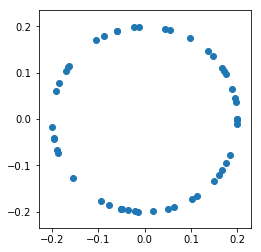

In [438]:
plt.scatter(F_test[0,0:N], F_test[1,0:N])
plt.gca().set_aspect('equal')
plt.show()

In [393]:
np.dot(F_test[:,0:N],F_test[:,0:N].T)

array([[  1.00000000e+00,  -7.89299182e-17],
       [ -7.89299182e-17,   1.00000000e+00]])

In [394]:
np.diag(np.dot(F_test[:,0:N].T,F_test[:,0:N]))

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [384]:
mu_vector

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [161]:
x = ortho_group.rvs(3)

In [164]:
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [idx for idx,item in enumerate(seq) if item in seen or seen_add(item)]

print(list_duplicates([1, 2, 3, 2, 1, 5, 6, 5, 5, 5]))
# [3, 4, 7, 8, 9]

[3, 4, 7, 8, 9]
